In [3]:
from matplotlib import pyplot as plt

from confutils import get_initial_structure, get_dihedral_info, set_dihedrals_and_relax, relax_structure
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import random

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from collections import deque
from keras_visualizer import visualizer
from graphviz import Digraph
import pydot_ng as pydot

This is my first go at the group project. It currently can one 1 round and actually does minimize energy. That's progress. I'm getting an error with the modified tensor board which I didnt make and I don't know what to do with it. That's my next prject. If you want to have a go at fixing it, be my guest.

# Things you can do:
    
   1) The convergence criterion doesn't work because it osicillates around a plateau and doesnt ever get to a point where it continually gets worse at the end. Please implement a new finishing criterion that takes the average over the last 100 steps. If the average over 100 steps stops changing significantly, we will define that plateau.
   -This requires that you look at the percentage that it changes by at each step and select a percentage that defines a plateau.
   
   
   2) You can pull your own version of this and try to define the intial functions and classes in .py files that can be imported. This got messy with the dependencies so I just shoved them all in here.
   3) Find a way to evaluate the accuracy of the fit and prediction of the q values. Add this to the DQNagent. Ask it to plot error as it goes so we can see how it's performing. 
   
   
   4) plot all energy values as each game progresses. Do you see any local minima
   
   
   5) the MAIN thing we need is to get it to run for multiple rounds.

In [4]:
def evaluate_energy(angles):
    """Compute the energy of a cysteine molecule given dihedral angles
    
    Args:
        angles: List of dihedral angles
    Returns:
        energy of the structure
    """
    return set_dihedrals_and_relax(
        cysteine,
        zip(angles, dihedrals)
    )

In [5]:
WIN_REWARD=100
MOVE_REWARD=1
epsilon=.9
eps_decay=.9998
start_q_table= None
learning=.1
discount=.95
def get_all(smiles,backbone_atoms,backbone_bonds):
    atoms, bonds = get_initial_structure(smiles)
   
    start_energy = relax_structure(atoms)
    diheds=[]
    for i in backbone_bonds:
        di=get_dihedral_info(bonds,i, backbone_atoms=backbone_atoms)
        diheds.append(di)
        
    init_state=np.random.uniform(-180,180,len(diheds))
    
    energy=set_dihedrals_and_relax(
        atoms,
        zip(init_state, diheds)
    )
    
    return atoms, diheds,energy,init_state

      
    
get_all('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])  

(Atoms(symbols='C2HCO2NSH6', pbc=False, constraint=FixInternals(_copy_init=[FixDihedral(18.902123048141277, [0, 1, 3, 5]), FixDihedral(-62.60246939063225, [3, 1, 0, 7]), FixDihedral(-83.64371381370478, [0, 1, 6, 11]), FixDihedral(-164.48621498151468, [1, 3, 5, 10]), FixDihedral(92.94376035341458, [1, 0, 7, 13])], epsilon=1e-07), calculator=Calculator(...)),
 [DihedralInfo(chain=[0, 1, 3, 5], group={10, 3, 4, 5}),
  DihedralInfo(chain=[3, 1, 0, 7], group={0, 7, 8, 9, 13}),
  DihedralInfo(chain=[0, 1, 6, 11], group={11, 12, 6}),
  DihedralInfo(chain=[1, 3, 5, 10], group={10, 5}),
  DihedralInfo(chain=[1, 0, 7, 13], group={13, 7})],
 -19641.683481143526,
 array([  18.90212305,  -62.60246939,  -83.64371381, -164.48621498,
          92.94376035]))

In [22]:
class Molecule:
    def __init__(self,smiles,backbone_atoms,backbone_bonds):
        self.bbonds=backbone_bonds
        self.n_choices=len(self.bbonds)
        self.atoms, self.dihedrals, self.energy, self.angles=get_all(smiles,backbone_atoms,backbone_bonds)
    def get_energy(self):
        self.energy=set_dihedrals_and_relax(self.atoms,zip(self.angles, self.dihedrals))
        return self.energy
    choices=[]
    #def action(self,choice):
        #if choice %2 ==0:
            #self.angles[int(choice/2)]+=1.0
            #if abs(self.angles[int(choice/2)])>180:
                #self.angles[int(choice/2)]=self.angles[int(choice/2)]%180
            
        #else:
            #self.angles[int(np.round(choice/2))]-=1.0
            #if abs(self.angles[int(choice/2)])>180:
                #self.angles[int(choice/2)]=self.angles[int(choice/2)]%180
                

    def action(self,choice):
        if choice==0:
            self.angles[0]+=1.0
            if abs(self.angles[0])>180:
                self.angles[0]=self.angles[0]%180
        if choice==1:
            self.angles[0]-=1.0
            if abs(self.angles[0])>180:
                self.angles[0]=self.angles[0]%180
        if choice==2:
            self.angles[1]+=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==3:
            self.angles[1]-=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==4:
            self.angles[1]+=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==5:
            self.angles[1]-=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==6:
            self.angles[1]+=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==7:
            self.angles[1]+=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==8:
            self.angles[1]+=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==9:
            self.angles[1]-=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
           


            
class MolEnv:
    mol = Molecule('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])
    SIZE = 360 #We dont have a finite size in this way
    RETURN_IMAGES = False
    ENERGY_REWARD=1
    MIN_REWARD = 25
    OBSERVATION_SPACE_VALUES = [360 for i in range(mol.n_choices)]
    OBSERVATION_SPACE_VALUES.append(mol.n_choices)
    ACTION_SPACE_SIZE = mol.n_choices*2
    OBSERVATION_SPACE_VALUES=tuple(OBSERVATION_SPACE_VALUES)
    reward=0
    MAX_STEPS=200000
    EXIT=False
    min_energy=mol.get_energy()+.05
    def __init__(self):
        self.energy_list=[]
        self.ener=self.mol.get_energy()
        self.min_energy=self.ener+.05
        self.reward=0
        self.EXIT==False
    def reset(self):
        self.mol = Molecule('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])
        self.ener=self.mol.get_energy()
        
        self.strikes=0
        self.energy_list=[]
        self.energy_list.append(self.ener)
        OBSERVATION_SPACE_VALUES = [360 for i in range(self.mol.n_choices)]
        OBSERVATION_SPACE_VALUES.append(self.mol.n_choices)# 4 #WHAT IS GOING ON HERE
        
        OBSERVATION_SPACE_VALUES=tuple(OBSERVATION_SPACE_VALUES)
        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = self.mol.angles
        return observation

    def step(self, action):
        self.reward=0
        self.episode_step += 1
        
        self.mol.action(action)
        new_ener=self.mol.get_energy()
        print(new_ener,"NEW EN")
        self.energy_list.append(new_ener)
    
        
        
        new_observation = self.mol.angles
        
        done = False
        
        if abs(new_ener)<=abs(self.min_energy):
            self.min_energy=new_ener
            self.reward=10000
            plt.plot(np.arange(0,len(self.energy_list)),self.energy_list)
            done = True

        if self.episode_step>MAX_STEPS and new_ener==self.min_energy:
            done=True
        

        
        return new_observation, self.reward, done, self.mol.angles

In [7]:
REPLAY_MEMORY_SIZE = 4000
MIN_REPLAY_MEMORY_SIZE = 1000
MODEL_NAME = "256x2"
DISCOUNT=0.99
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MIN_EPSILON=.5
class DQNAgent:
    
    def __init__(self,env):

        # main model  # gets trained every step
        self.model = self.create_model()

        # Target model this is what we .predict against every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0

    def create_model(self):
        
        model = Sequential()
        #model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))
        #model.add(keras.Input(shape=(REPLAY_MEMORY_SIZE,a1.n_choices)))
        model.add(keras.Input(shape=(a1.n_choices)))
        model.add(Dense(a1.n_choices))

        #model.add(Flatten())
        
        model.add(Dense(a1.n_choices,activation='linear'))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def get_qs(self, state, step):
        #print(*state.shape)
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/180)[0]
    def train(self, terminal_state,step):
        if len(self.replay_memory)<MIN_REPLAY_MEMORY_SIZE:
            return
    # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/180
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/180
        future_qs_list = self.target_model.predict(new_current_states)
        
        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Tabel Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/180, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        # Update target network counter every episode
                # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

In [8]:

a1=Molecule('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])
print(a1.angles)
a1.action(2)
print(a1.angles)

[ 102.10712711   38.55490844  162.19888513  -91.48728529 -161.84671205]
[ 102.10712711   39.55490844  162.19888513  -91.48728529 -161.84671205]


# This is the part that actually runs the code

In [9]:
env=MolEnv()
EPISODES = 5
agent = DQNAgent(env)
epsilon=.9
EPSILON_DECAY=.98
AGGREGATE_STATS_EVERY=10
MAX_STEPS=200#000

 20%|###############6                                                              | 1/5 [00:32<02:08, 32.07s/episodes]

-19641.045079097203 NEW EN
-19641.391229316538 NEW EN
-19641.388440011022 NEW EN
-19641.39122951928 NEW EN
-19641.392889762254 NEW EN
-19641.39554079866 NEW EN
-19641.393932051804 NEW EN
-19641.39654943327 NEW EN
-19641.3990832856 NEW EN
-19641.401557532183 NEW EN
-19641.400236879752 NEW EN
-19641.397700594538 NEW EN
-19641.395106933727 NEW EN
-19641.397700391797 NEW EN
-19641.400236068792 NEW EN
-19641.397699986315 NEW EN
-19641.400236879752 NEW EN
-19641.399043953916 NEW EN
-19641.396439142372 NEW EN
-19641.399043548437 NEW EN
-19641.39798017386 NEW EN
-19641.400629993823 NEW EN
-19641.40326683839 NEW EN
-19641.402513454228 NEW EN
-19641.40326764935 NEW EN
-19641.405897803477 NEW EN
-19641.403268460315 NEW EN
-19641.402512035045 NEW EN
-19641.405235652597 NEW EN
-19641.407954404374 NEW EN
-19641.405235247115 NEW EN
-19641.402514467933 NEW EN
-19641.401902191246 NEW EN
-19641.401431022034 NEW EN
-19641.401104204146 NEW EN
-19641.404105981837 NEW EN
-19641.404339741777 NEW EN
-19641.40

 20%|###############4                                                             | 1/5 [10:44<42:58, 644.60s/episodes]


KeyboardInterrupt: 

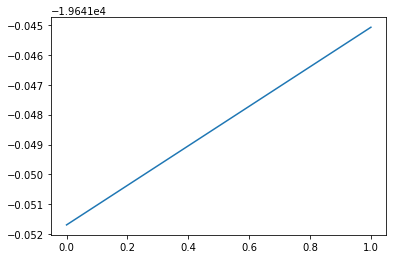

In [24]:
SHOW_PREVIEW=False
ep_rewards=[]
angles_list=[]
#energy_min=-1941.0 #This needs to be defined for each structure. This should be the open babel gradient descent min. 
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    #while env.EXIT==False:

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state,step))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done, ANGLES = env.step(action)
        angles_list.append(ANGLES)
        

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1
    #episode+=1
    #print("DONE")
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        #if min_reward >= MIN_REWARD:
            #agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
plt.legend([str(i) for i in range(EPISODES)])


In [25]:
def create_model(self):
        
        model = Sequential(name = 'DQN: Cysteine')
        #model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))
        #model.add(keras.Input(shape=(REPLAY_MEMORY_SIZE,a1.n_choices)))
        model.add(keras.Input(shape=(a1.n_choices)))
        model.add(Dense(a1.n_choices))

        #model.add(Flatten())
        
        model.add(Dense(a1.n_choices,activation='linear'))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model


In [26]:
model = create_model(env)

In [27]:
model.summary()

Model: "DQN: Cysteine"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                60        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [13]:
pydot.find_graphviz()

In [20]:
visualizer(model, filename = r"C:\Users\ascoh\graph", format = 'png', view = True)